In [5]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import sys
sys.path.append("../src")
DATA = Path("../data")
BUSINESS = DATA / "business.json"
USER = DATA / "user.json"
REVIEW = DATA / "review.json"
SAVEPATH = DATA / "yelp.csv"
YELP = DATA / "yelp_v2.csv"

In [2]:
from sklearn.preprocessing import StandardScaler
df = pd.read_csv(YELP)
# Don't know how to handle postal codes
df.drop(columns=['postal_code'], inplace=True)
for col in df.columns:
    un = df[col].unique()
    # Standardize all non-categorical variables
    if len(un) <= 3 or col in ['RestaurantsPriceRange2', 'stars', 'rating']:
        continue
    print(col, len(un))
    df[col] = StandardScaler().fit_transform(df[col].to_numpy().reshape(-1, 1))

review_count 498
longitude 17793
latitude 17970
compliment_plain 1195
useful 3894
compliment_writer 705
funny 2783
compliment_profile 292
compliment_cute 264
compliment_funny 1238
compliment_note 759
fans 527
compliment_photos 668
compliment_cool 1238
compliment_hot 1051
cool 3155
review_count.1 498
average_stars 396
compliment_more 302
friends 2081
compliment_list 174
time 475694


In [65]:
df['friends']

0        -0.312173
1        -0.181269
2        -0.309607
3        -0.255705
4         0.545124
            ...   
499369   -0.050364
499370    0.945538
499371   -0.301906
499372   -0.309607
499373   -0.304473
Name: friends, Length: 499374, dtype: float64

## Logistic Regression (Baseline)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [68]:
X = df.drop(columns=['rating'])
y = df['rating'] >= 5.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.7461902214491891
0.7467976744341279


## Decision Trees

In [70]:
from sklearn import tree

In [75]:
X = df.drop(columns=['rating'])
y = df['rating']# >= 5.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [76]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9999914178069064
0.4592191598859912


In [74]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9999971392689688
0.6834520368726346


## Dimension Reduction

In [77]:
from sklearn.feature_selection import SelectKBest, chi2

In [78]:
Xnew = SelectKBest(chi2, k=2).fit_transform(X_train, y_train)

ValueError: Input X must be non-negative.

# Ensemble Methods

## Random Forest

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [208]:
X = df.drop(columns=['rating'])
y = df['rating'] >= 5.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9840685888872043
0.7379866900736252


0.8020391424822544
[2.    1.    0.9   0.875 0.8   0.775 0.7   0.675 0.62  0.6   0.5   0.4
 0.3   0.275 0.22  0.2   0.1   0.   ]


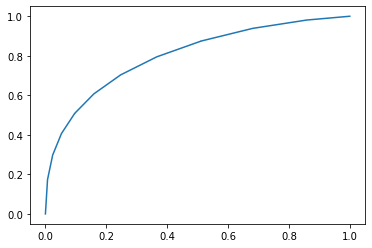

In [216]:
FP, TP, thresh = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(FP, TP)
print(roc_auc)
print(thresh)
plt.plot(FP, TP)

In [84]:
train = []
test = []
N_estimators = list(range(1, 20))
for n_estimators in tqdm(N_estimators):
    clf = RandomForestClassifier(n_estimators=n_estimators)
    clf = clf.fit(X_train, y_train)
    train.append(clf.score(X_train, y_train))
    test.append(clf.score(X_test, y_test))

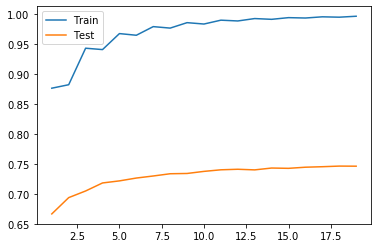

In [87]:
plt.plot(N_estimators, train, label='Train')
plt.plot(N_estimators, test, label='Test')
plt.legend()

In [88]:
from sklearn.metrics import *

In [90]:
X = df.drop(columns=['rating'])
y = df['rating']# >= 5.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)

array([[ 50258,     34,     24,     67,    263],
       [   362,  27689,     46,    132,    238],
       [   202,     75,  37896,    225,    359],
       [   206,     76,    190,  76299,    733],
       [   277,     69,    134,    645, 153062]])

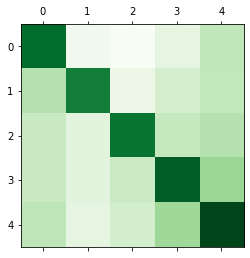

In [96]:
conf = confusion_matrix(y_train, clf.predict(X_train))
plt.matshow(np.log10(conf), cmap='Greens')

## Extremely Randomized Trees

In [222]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import scikitplot as sklplt

In [227]:
X = df.drop(columns=['rating'])
y = df['rating']# >= 5.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [230]:
clf = ExtraTreesClassifier(n_estimators = 10)
clf.fit(X_train, y_train)
probas = clf.predict_proba(X_test)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9999914178069064
0.5054434528378712


0.7910463593859712
[2.   1.   0.9  0.8  0.7  0.6  0.5  0.45 0.4  0.3  0.25 0.2  0.15 0.1
 0.  ]


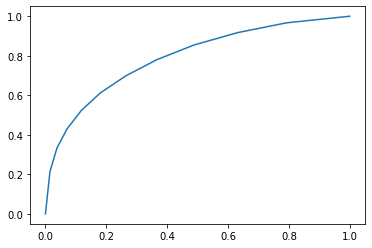

In [220]:
FP, TP, thresh = roc_curve(y_test, probas[:, 1])
roc_auc = auc(FP, TP)
print(roc_auc)
print(thresh)
plt.plot(FP, TP)

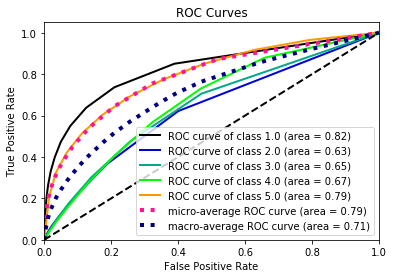

In [231]:
sklplt.metrics.plot_roc(y_test, probas)

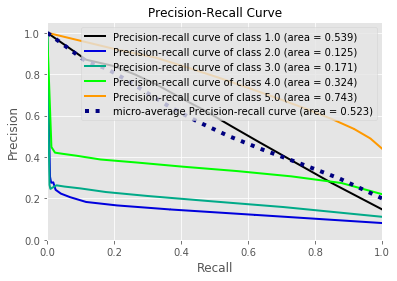

In [243]:
with plt.style.context('ggplot'):
    ax = sklplt.metrics.plot_precision_recall_curve(y_test, probas)

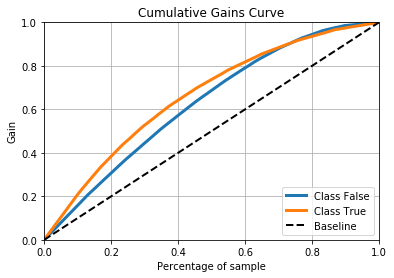

In [225]:
sklplt.metrics.plot_cumulative_gain(y_test, clf.predict_proba(X_test))

In [100]:
extra_train = []
extra_test = []
N_estimators = list(range(1, 20))
for n_estimators in tqdm(N_estimators):
    clf = ExtraTreesClassifier(n_estimators=n_estimators)
    clf = clf.fit(X_train, y_train)
    extra_train.append(clf.score(X_train, y_train))
    extra_test.append(clf.score(X_test, y_test))

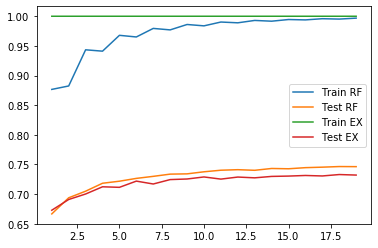

In [101]:
plt.plot(N_estimators, train, label='Train RF')
plt.plot(N_estimators, test, label='Test RF')
plt.plot(N_estimators, extra_train, label='Train EX')
plt.plot(N_estimators, extra_test, label='Test EX')
plt.legend()

Feature ranking:
1. average_stars 0.18656325354930842
2. stars 0.0884664549464527
3. time 0.07472648665382915
4. useful 0.06316165784672169
5. friends 0.053658119961149386
6. cool 0.05322773938356912
7. funny 0.052541223248244166
8. fans 0.03364736303060011
9. compliment_plain 0.03048886918471767
10. compliment_note 0.02921618097647651
11. compliment_writer 0.0227059281021783
12. compliment_cool 0.021088410133570334
13. compliment_funny 0.021068846849878448
14. compliment_hot 0.019360448797177663
15. compliment_more 0.01813806913499121
16. longitude 0.01708764327570498
17. latitude 0.017052361036021264
18. review_count.1 0.016960398667777165
19. review_count 0.016889668150590984
20. compliment_photos 0.016655027409853935
21. compliment_profile 0.01039204526290687
22. compliment_cute 0.009207492195005936
23. RestaurantsPriceRange2 0.006465451841919635
24. compliment_list 0.005607917052038169
25. WheelchairAccessible 0.0055899823269658444
26. Caters 0.005198127342804492
27. BusinessAccep

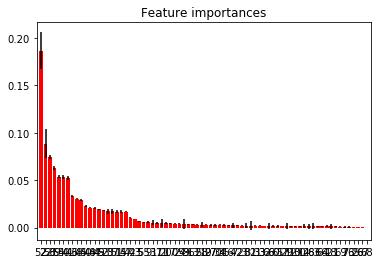

In [104]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print(f"{f+1}. {df.columns[indices[f]]} {importances[indices[f]]}")
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## AdaBoost

In [3]:
from sklearn.ensemble import AdaBoostClassifier
import scikitplot as sklplt

In [10]:
X = df.drop(columns=['rating'])
y = df['rating']# >= 5.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [11]:
clf = AdaBoostClassifier(n_estimators=10)
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_test)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.538887347272722
0.5409944397348695


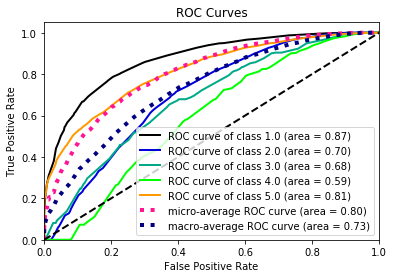

In [12]:
sklplt.metrics.plot_roc_curve(y_test, proba)

In [ ]:
sklplt.metrics.plot

In [111]:
ada_train = []
ada_test = []
N_estimators = [1, 5, 10, 15, 20, 30, 35, 40, 50, 60, 70, 80, 100]
for n_estimators in tqdm(N_estimators):
    clf = AdaBoostClassifier(n_estimators=n_estimators)
    clf = clf.fit(X_train, y_train)
    ada_train.append(clf.score(X_train, y_train))
    ada_test.append(clf.score(X_test, y_test))

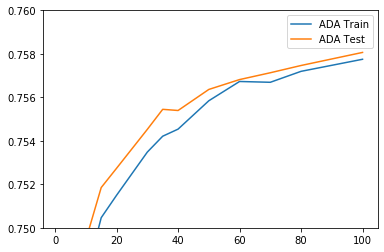

In [115]:
plt.plot(N_estimators, ada_train, label="ADA Train")
plt.plot(N_estimators, ada_test, label="ADA Test")
plt.ylim([0.75, 0.76])
plt.legend()

## Decomposition

In [199]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from ensemble import Ensemble

D = df[:10000]
X = D.drop(columns=['rating'])
y = D['rating'] >= 5.0
ensemble = Ensemble(X, y, num_members=50)
hyperparameters = [1, 3, 5, 8, 10, 15, 20, 25, 30, 35, 50]
hyperparameters = [None] + list(range(1, 20))
ensemble.run(lambda x: RandomForestClassifier(n_estimators=10, max_depth=x), hyperparameters)

(20, 50)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35a3b05670>)

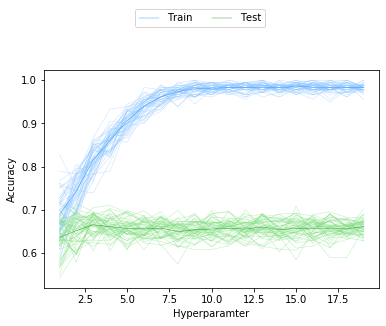

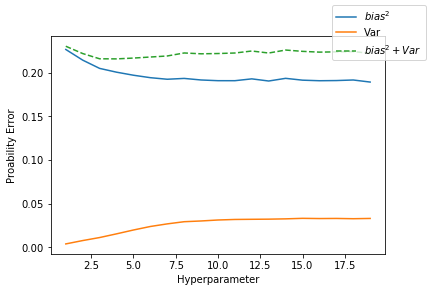

In [200]:
ensemble.plot_train_test()
ensemble.plot_decomposition()